In [1]:
# pip install openpyxl

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import gamma, poisson
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Úloha 1

## Konjugované apriorní a aposteriorní rozdělení, prediktivní rozdělení

Načtení dat

In [51]:
# Load data from Excel file
# data = pd.read_excel('c:\\Users\\user\\Documents\\Projekt-2_Data.xlsx')
data = pd.read_excel('c:\\Users\\M\\Documents\\Projekt-2_Data.xlsx')

# Display the loaded data
print(data)


       uloha_1 a)  uloha_1 b)_prior  skupina  uloha_1 b)_pozorování
0             2.0          3.634785        0               3.626656
1             2.0          2.868113        0               3.008269
2             1.0          2.149160        0               2.989829
3             3.0          4.263065        0               2.371630
4             0.0          2.594745        0               4.009366
...           ...               ...      ...                    ...
99995         NaN          1.725637     9999                    NaN
99996         NaN          4.048414     9999                    NaN
99997         NaN          3.000662     9999                    NaN
99998         NaN          3.058451     9999                    NaN
99999         NaN          4.487418     9999                    NaN

[100000 rows x 4 columns]


Z expertního odhadu víme, že každou 1 ms dojde k 2 připojením. Expertní odhad parametru lambda je tedy roven 2.

Z tabulek (https://en.wikipedia.org/wiki/Conjugate_prior) vidíme, že konjugované apriorní rozdělení je Gamma rozdělení s parametry 'k' a 'lambda'. Víme, že máme 2 připojení za 1 ms, tj. E(X) = k/lambda = 2/1 = 2.



In [ ]:
pip install conjugate-prior

In [63]:
data["uloha_1 a)"].dropna()

0     2.0
1     2.0
2     1.0
3     3.0
4     0.0
     ... 
95    3.0
96    0.0
97    3.0
98    1.0
99    1.0
Name: uloha_1 a), Length: 100, dtype: float64

Assuming first parameter is the Expectancy


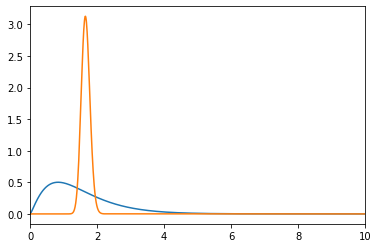

In [70]:
from conjugate_prior import GammaPoisson

alpha = 2 # Shape parameter
beta = 1 # Rate parameter
prior_model = GammaPoisson(alpha) # Uninformative prior
updated_model = prior_model.update(alpha, beta)
updated_model.plot()

# predictive = updated_model.predict(50, 50)
# print ("The chance of flipping 50 Heads and 50 Tails in 100 trials is {p:.2f}%".format(p=predictive*100))
posterior = updated_model.update(data["uloha_1 a)"].dropna())
posterior.plot()

In [82]:
# Your prior parameters
alpha = 2
beta = 1

# Create an uninformative prior
prior_model = GammaPoisson(alpha)

# Update the prior with your data
posterior_model = prior_model.update(data["uloha_1 a)"].dropna())

# Get the data for the credibility interval calculation
lambda_values = data["uloha_1 a)"].dropna()

# Calculate the percentiles for the prior and posterior distributions


Assuming first parameter is the Expectancy


AttributeError: 'GammaPoisson' object has no attribute 'percentile'

C:\Users\M\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 120582 (\N{MATHEMATICAL ITALIC SMALL LAMDA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


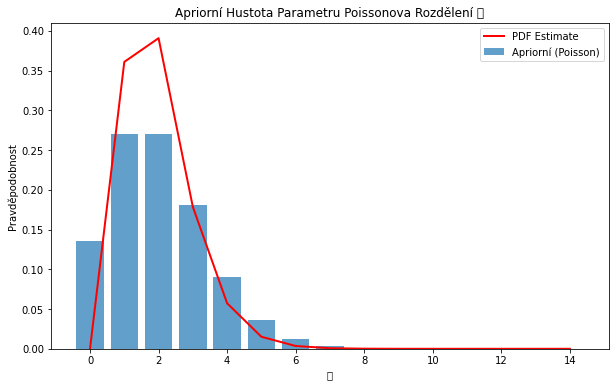

In [4]:
# Expert information
lambda_expert = 2

# Generate x values for the Poisson distribution
x_values = np.arange(0, 15)

# Calculate PMF values for the apriori distribution
pmf_apriori = poisson.pmf(x_values, mu=lambda_expert)
# pmf_aposteriori = poisson.pmf(x_values, mu=2*lambda_expert)


# Calculate PDF values for a smoother representation
pdf_apriori = gamma.pdf(x_values, a=lambda_expert**2, scale=1/lambda_expert)

# Plot the apriori distribution
plt.figure(figsize=(10, 6))
plt.bar(x_values, pmf_apriori, label='Apriorní (Poisson)', alpha=0.7)
# plt.bar(x_values, pmf_aposteriori, label='Aposteriorni (Poisson)', alpha=0.7)

plt.plot(x_values, pdf_apriori, color='red', label='PDF Estimate', linewidth=2)
plt.title('Apriorní Hustota Parametru Poissonova Rozdělení 𝜆')
plt.xlabel('𝜆')
plt.ylabel('Pravděpodobnost')
plt.legend()
plt.show()

## Aproximace diskrétním rozdělením

1. podúloha
- Tu sme mali viacero problémov. Prvý bol s tvorbou apriórneho rozdelenia pre parameter
"b". Postup, ktorí väčšina z nás zvolila bol nasledujúci:
V každej skupine (z 10 000 skupín, kde každá mala 10 nameraných hodnôt) sme našli
najväčšiu hodnotu. Týchto 10 000 hodnôt sme dali do jednej dátovej sady a vytvorili sme z
nich diskrétne rozdelenie. Toto diskrétne rozdelenie bolo urobené rozdelením všetkých 10
000 hodnôt na intervaly. (Napríklad celý interval hodnôt rozdelíme na 50 intervalov o
rovnakej šírke). Takto bolo získané (žlté) diskrétne apriórne rozdelenie uložené v obrázku
"output.png" v prílohe tohto mailu. Každému intervalu vieme dať "predstaviteľa", t.j.
napríklad stred daného intervalu. Týmto získame diskrétne rozdelenie, ktoré má 50 možných
vstupov, t.j. 50 rôznych parametrov "b" (stredy intervalov) s rôznymi pravdepodobnosťami.

2. podúloha
- Tvorba aposteriórneho rozdelenia je opísaná v obrázku "rovnica.png". Táto celá rovnica
predstavuje výpočet aposteriórnej pravdepodobnosti pre 1 konkrétny parameter "b". Celkové
aposteriórne rozdelenie je zobrazené na obrázku "output.png" červenou farbou. Výpočet
funguje klasicky na základe bayesovského odhadu pre diskrétne rozdelenia a naše
aposteriórne rozdelenie pre parameter "b" je:
P(b_1 | x) = P(x | b_1) * h(b_1) / Σ( P(x | b_i) * h(b_i) )
P(b_2 | x) = P(x | b_2) * h(b_2) / Σ( P(x | b_i) * h(b_i) )
P(b_3 | x) = P(x | b_3) * h(b_3) / Σ( P(x | b_i) * h(b_i) )
...
P(b_50 | x) = P(x | b_50) * h(b_50) / Σ( P(x | b_i) * h(b_i) )
Avšak, keďže my máme vektor dát D o dĺžke 100, musíme tieto rovnice upraviť:
P(b_1 | D) = P(d_1 | b_1) * ... * P(d_100 | b_1) * h(b_1) / Σ( P(d_1 | b_i) * ... * P(d_100 |
b_i) * h(b_i) )
prepíšeme na kratší zápis:
P(b_1 | D) = Π P(d_i | b_1) * h(b_1) / Σ_i( Π_j (d_j | b_i) * h(b_i) )
P(b_2 | D) = Π P(d_i | b_2) * h(b_1) / Σ_i( Π_j (d_j | b_i) * h(b_i) )
P(b_3 | D) = Π P(d_i | b_3) * h(b_1) / Σ_i( Π_j (d_j | b_i) * h(b_i) )
...
P(b_50 | D) = Π P(d_i | b_50) * h(b_1) / Σ_i( Π_j (d_j | b_i) * h(b_i) )
Otázka je:
Je správne povedať, že tieto funkcie dokopy tvoria jedno finálne aposteriórne rozdelenie (v
output.png červená)?
P(b_1 | D), P(b_2 | D), P(b_3 | D), ..., P(b_50 | D)
Je správne povedať, že tieto funkcie dokopy tvoria jednu finálnu vierohodnostnú funkciu (v
output.png modrá)?
Π P(d_i | b_1), Π P(d_i | b_2), Π P(d_i | b_3), ..., Π P(d_i | b_50)

# Úloha 2

### Čištění dat

In [5]:
# read data from the second sheet
# data = pd.read_excel('c:\\Users\\user\\Documents\\Projekt-2_Data.xlsx', sheet_name=1)
data = pd.read_excel('c:\\Users\\M\\Documents\\Projekt-2_Data.xlsx', sheet_name=1)

# Display the loaded data
print(data)


      OSType  ActiveUsers  InteractingPct  ScrollingPct  Ping [ms]
0        iOS         4113          0.8283        0.1717         47
1        iOS         7549          0.3461        0.6539         46
2    Windows         8855          0.2178        0.7822         55
3    Android         8870          0.0794        0.9206         56
4      MacOS         9559          0.7282        0.2718         76
..       ...          ...             ...           ...        ...
497      iOS         5315          0.1974        0.8026         28
498    MacOS         1392          0.2373        0.7627         24
499      iOS         6014          0.8112        0.1888         54
500  Android         5118          0.2345        0.7655         39
501    MacOS         2660          0.9390        0.0610         55

[502 rows x 5 columns]


Vidíme, že atributy InteractingPct a ScrollingPct jsou na sobě zřejmě závislé, neboť lze spočítat jeden z druhého a naopak (např. 1-InteractingPct=ScrollingPct). Můžeme si tedy bez újmy na kvalitě dovolit vyřadit 1 z těchto parametrů.

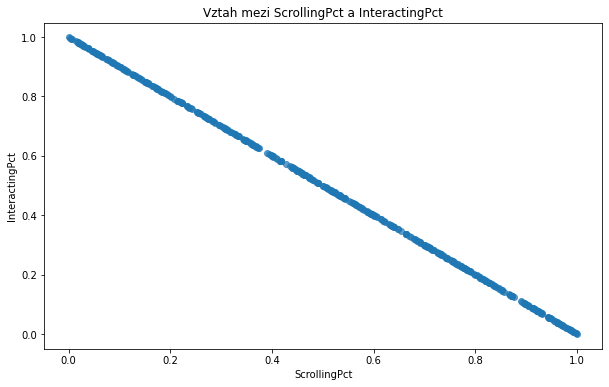

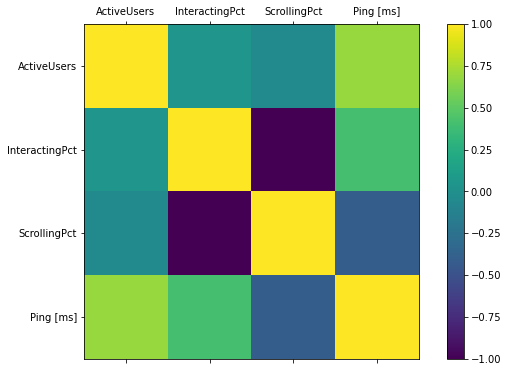

      OSType  ActiveUsers  InteractingPct  Ping
0        iOS         4113          0.8283    47
1        iOS         7549          0.3461    46
2    Windows         8855          0.2178    55
3    Android         8870          0.0794    56
4      MacOS         9559          0.7282    76
..       ...          ...             ...   ...
497      iOS         5315          0.1974    28
498    MacOS         1392          0.2373    24
499      iOS         6014          0.8112    54
500  Android         5118          0.2345    39
501    MacOS         2660          0.9390    55

[502 rows x 4 columns]


In [6]:
# plot relationship between ScrollingPct   and InteractingPct
plt.figure(figsize=(10, 6))
plt.scatter(data['ScrollingPct'], data['InteractingPct'], alpha=0.7)
plt.title('Vztah mezi ScrollingPct a InteractingPct')
plt.xlabel('ScrollingPct')
plt.ylabel('InteractingPct')
plt.show()

# plot correlation matrix of numeric variables
# first select only numeric variables
numeric_variables = data.select_dtypes(include=[np.number])
# then plot the correlation matrix
plt.figure(figsize=(10, 6))
plt.matshow(numeric_variables.corr(), fignum=1)
plt.xticks(range(len(numeric_variables.columns)), numeric_variables.columns)
plt.yticks(range(len(numeric_variables.columns)), numeric_variables.columns)
plt.colorbar()
plt.show()

# drop ScrollingPct column
data = data.drop('ScrollingPct', axis=1)
data = data.rename(columns={'Ping [ms]': 'Ping'})
print(data)

### Splnění předpokladů lineární regrese a základní regresní diagnostiky

### Analýza odlehlých hodnot

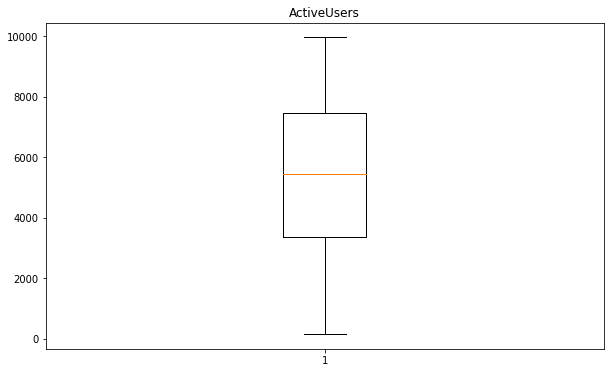

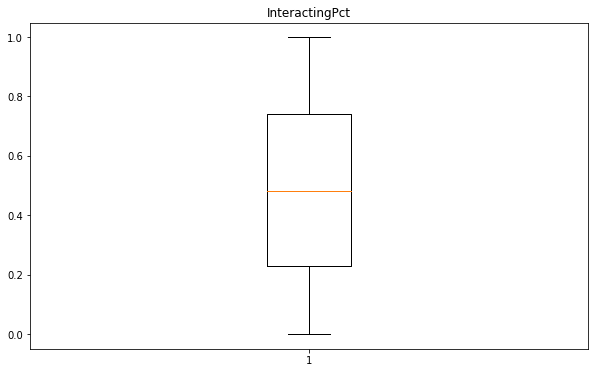

       ActiveUsers  InteractingPct        Ping
count   502.000000      502.000000  502.000000
mean   5485.830677        0.488613   50.545817
std    2548.935679        0.296000   14.797937
min     153.000000        0.000500   11.000000
25%    3357.500000        0.229300   40.000000
50%    5456.000000        0.482950   52.000000
75%    7461.500000        0.742475   60.000000
max    9953.000000        0.998600   90.000000


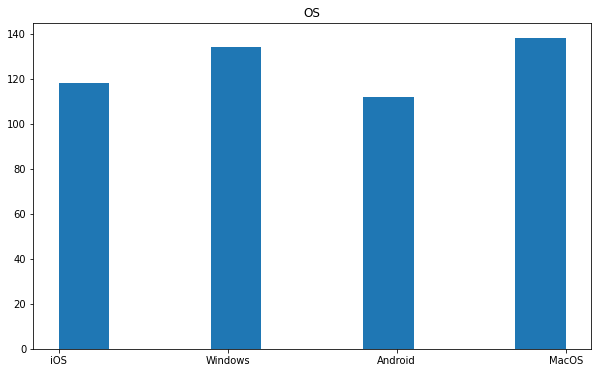

In [7]:
# using visualizations to explore the data (outliers), for each column extra boxplot with appropriate range of values
# for each column extra boxplot with appropriate range of values in one figure
plt.figure(figsize=(10, 6))
plt.boxplot(data['ActiveUsers'])
plt.title('ActiveUsers')
plt.show()

plt.figure(figsize=(10, 6))
plt.boxplot(data['InteractingPct'])
plt.title('InteractingPct')
plt.show()

# analyze the data using the describe() method
print(data.describe())

# histogram for OS column
plt.figure(figsize=(10, 6))
plt.hist(data['OSType'])
plt.title('OS')
plt.show()

### Others

In [8]:
# 1. option
mod = smf.ols(formula='Ping ~ ActiveUsers + InteractingPct + C(OSType) + ActiveUsers*InteractingPct', data=data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     302.0
Date:                Fri, 08 Dec 2023   Prob (F-statistic):          7.08e-162
Time:                        16:43:23   Log-Likelihood:                -1678.1
No. Observations:                 502   AIC:                             3370.
Df Residuals:                     495   BIC:                             3400.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [9]:
# 2. option with dummy variables
# https://www.statsmodels.org/stable/example_formulas.html
# https://stackoverflow.com/questions/55738056/using-categorical-variables-in-statsmodels-ols-class
# 
# create dummy variables for OS column (one-hot encoding) and use it in the model instead of the original column OS column 
data1 = pd.get_dummies(data, columns=['OSType']).astype(float)

mod = smf.ols(formula='Ping ~ ActiveUsers + InteractingPct + C(OSType_Android) + C(OSType_iOS) + C(OSType_Windows) + C(OSType_MacOS) + ActiveUsers*InteractingPct', data=data1)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     302.0
Date:                Fri, 08 Dec 2023   Prob (F-statistic):          7.08e-162
Time:                        16:43:23   Log-Likelihood:                -1678.1
No. Observations:                 502   AIC:                             3370.
Df Residuals:                     495   BIC:                             3400.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Je logické, že pro 4 kategorie nám stačí mít v modelu pouze 3, jelikož 4. kategorii jsme schopni dopočítat.

**Ping=11.2525+9.3104×MacOS+3.5404×Windows−5.8093×iOS+0.0053×ActiveUsers+32.8854×InteractingPct−0.0029×ActiveUsers×InteractingPct**



### Předpoklady lineární regrese a základní regresní diagnostiky

Diagnostika
- ověření základních předpokladů MNČ (kritika metody):
ověření stejného rozptylu, ověření autokorelace (Durbin-Watson), ověření normality (Omnibus; Prob(Omnibus); Jarque-Bera (JB); Prob(JB))
- ověření vhodnosti modelu pro daná data (kritika modelu):
ověření, zda v datech je nějaká závislost, ověření kvality modelu
- vhodnosti dat pro navržený regresní model (kritika dat):
zjištění vlivných bodů, vlivné body v nezávisle proměnných, vlivné body v závisle proměnných 

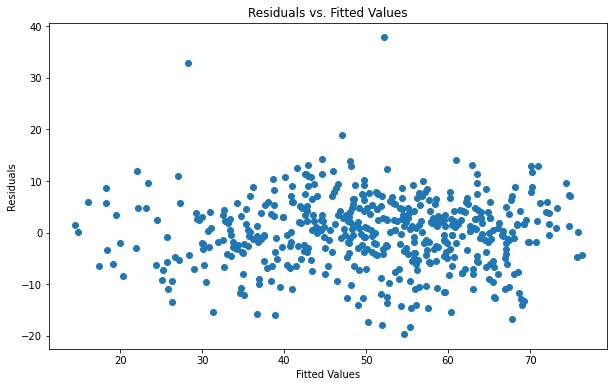

<Figure size 720x432 with 0 Axes>

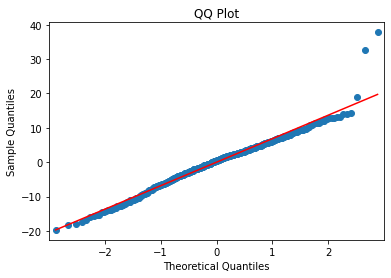

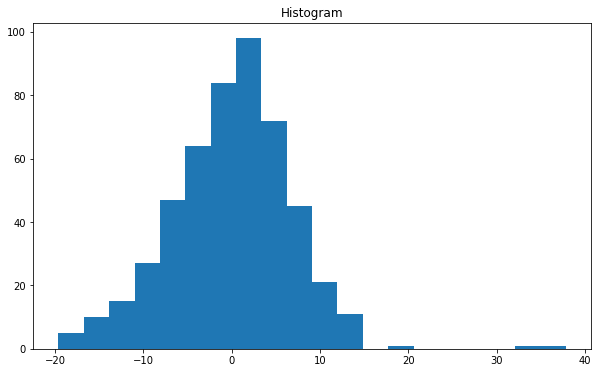

In [10]:
# visualize the residuals of the model
plt.figure(figsize=(10, 6))
plt.scatter(res.fittedvalues, res.resid)
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# using QQ plot to check the normality of the residuals
plt.figure(figsize=(10, 6))
sm.qqplot(res.resid, line='s')
plt.title('QQ Plot')
plt.show()

# using histogram to check the normality of the residuals
plt.figure(figsize=(10, 6))
plt.hist(res.resid, bins=20)
plt.title('Histogram')
plt.show()


255
OSType            Windows
ActiveUsers          5513
InteractingPct     0.4912
Ping                   90
Name: 255, dtype: object

476
OSType             MacOS
ActiveUsers          153
InteractingPct    0.2111
Ping                  61
Name: 476, dtype: object

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     340.6
Date:                Fri, 08 Dec 2023   Prob (F-statistic):          8.85e-172
Time:                        16:43:24   Log-Likelihood:                -1643.9
No. Observations:                 500   AIC:                             3302.
Df Residuals:                     493   BIC:                             3331.
Df Model:                           6                                         
Covariance Type:         

<Figure size 720x432 with 0 Axes>

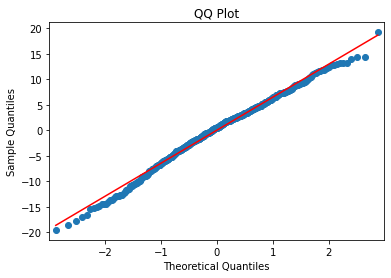

In [11]:
# indentify outliers
outliers = res.resid[res.resid > 20]
for i in outliers.index:
    print(i)
    print(str(data.iloc[i]) + "\n")

# delete outliers
data = data.drop(outliers.index)
data = data.reset_index(drop=True)

mod = smf.ols(formula='Ping ~ ActiveUsers + InteractingPct + C(OSType) + ActiveUsers*InteractingPct', data=data)
res = mod.fit()
print(res.summary())

plt.figure(figsize=(10, 6))
sm.qqplot(res.resid, line='s')
plt.title('QQ Plot')
plt.show()

### Odhadněte hodnotu odezvy uživatele s Windows, při průměrném nastavení ostatních parametrů a vypočtěte konfidenční interval a predikční interval pro toto nastavení.

In [24]:
data.columns

Index(['OSType', 'ActiveUsers', 'InteractingPct', 'Ping'], dtype='object')

In [50]:
# Odhadněte hodnotu odezvy uživatele s Windows, při průměrném nastavení ostatních parametrů a vypočtěte konfidenční interval a predikční interval pro toto nastavení.
# calculate mean values of numeric variables in data
numeric_variables = data.select_dtypes(include=[np.number])
# calculate mean values
mean_numeric_values = numeric_variables.mean().drop('Ping')
# add OSType column
mean_numeric_values['OSType'] = 'Windows'
input_values = pd.DataFrame([mean_numeric_values])
# provide model with input values
# predict the response
predicted_values = res.predict(input_values)
print(f'Predicted ping: {predicted_values}')
print(mean_numeric_values)

# select all records where OSType is Windows
data_windows = data[data['OSType'] == 'Windows']
predicted_values = res.get_prediction(data_windows)
pred = predicted_values.summary_frame(alpha=0.05) #95% intervaly
X_new = pd.DataFrame({'x':np.arange(min(data["Ping"]),max(data["Ping"]),0.5)})
# # plot prediction interval 
# plt.plot(np.array(X_new['x']),np.array(pred['mean']))
# plt.grid(True)
# plt.fill_between(np.array(X_new['x']), np.array(pred['mean_ci_lower']) , np.array(pred['mean_ci_upper']), color='b', alpha=0.15)
# plt.fill_between(np.array(X_new['x']), np.array(pred['obs_ci_lower']) , np.array(pred['obs_ci_upper']), color='g', alpha=0.15)
# plt.xlabel('x')
# plt.ylabel('y - response')
# plt.show()
pred['mean']

Predicted ping: 0    51.815227
dtype: float64
ActiveUsers       5496.442
InteractingPct    0.489163
OSType             Windows
dtype: object


0      63.059135
1      54.005923
2      50.410972
3      68.705706
4      39.901052
         ...    
128    58.432435
129    57.698902
130    56.355355
131    32.795570
132    40.270215
Name: mean, Length: 133, dtype: float64